In [1]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

In [29]:
# CONVERT ERA5 DEWPOINT TEMPERATURE TO RELATIVE HUMIDITY
import xarray as xr
import numpy as np
era5_dt = xr.open_dataset('~/research/climate_data/ERA5/ERA5_hourly/ERA5_dtemp_hourly.nc')
era5_t = xr.open_dataset('~/research/climate_data/ERA5/ERA5_hourly/ERA5_temp_hourly.nc')
def vapor_pressure(T,units='K'):
    if units=='K':
        T -= 273.15
    P = 0.61094*np.exp(17.625*T/(T+243.04)) # kPa
    return P*1000
era5_vp = vapor_pressure(era5_dt.d2m.values) / vapor_pressure(era5_t.t2m.values)
era5_out = era5_dt.copy()
era5_out['rh'] = (['time','latitude','longitude'],era5_vp)
era5_out = era5_out.drop_vars('d2m')
era5_out = era5_out.assign_attrs({'units':'0-1','long_name':'2 metre relative humidity'})
print(era5_out)
# era5_out.plot.scatter('time','rh')
era5_out.to_netcdf('~/research/climate_data/ERA5/ERA5_hourly/ERA5_rh_hourly.nc')

<xarray.Dataset>
Dimensions:    (longitude: 1, latitude: 1, time: 368184)
Coordinates:
  * longitude  (longitude) float32 -145.5
  * latitude   (latitude) float32 63.34
  * time       (time) datetime64[ns] 1980-01-01 ... 2021-12-31T23:00:00
Data variables:
    rh         (time, latitude, longitude) float32 0.9798 0.9804 ... 0.9888
Attributes:
    units:      0-1
    long_name:  2 metre relative humidity


In [40]:
# CONVERT MERRA2 SPECIFIC HUMIDITY TO RELATIVE HUMIDITY
import xarray as xr
import numpy as np
merra2_qv = xr.open_dataset('~/research/climate_data/MERRA2/QV2M/MERRA2_QV2M_60_-150.nc')
merra2_sp = xr.open_dataset('~/research/climate_data/MERRA2/PS/MERRA2_PS_60_-150.nc')
merra2_t = xr.open_dataset('~/research/climate_data/MERRA2/T2M/MERRA2_T2M_60_-150.nc')
def vapor_pressure(T,units='K'):
    if units=='K':
        T -= 273.15
    P = 0.61094*np.exp(17.625*T/(T+243.04)) # kPa
    return P*1000
esat = vapor_pressure(merra2_t.T2M.values)
ws = 0.622*esat / merra2_sp.PS.values
w = merra2_qv.QV2M.values
rh = w / ws
merra2_out = merra2_qv.copy()
merra2_out['RH'] = (['time','lat','lon'],rh)
merra2_out = merra2_out.drop_vars('QV2M')
merra2_out.to_netcdf('~/research/climate_data/MERRA2/RH2M/MERRA2_RH2M_60_-150.nc')

2015 0.00012285003


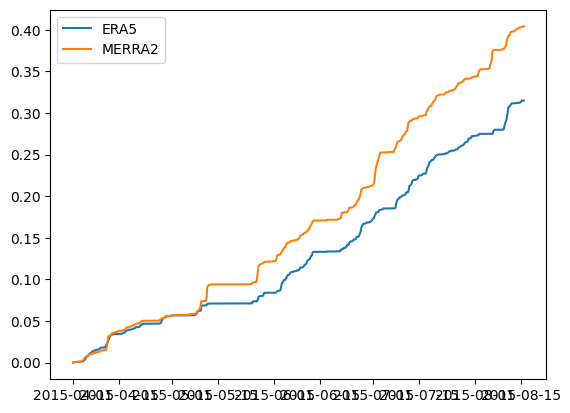

2016 0.00015638002


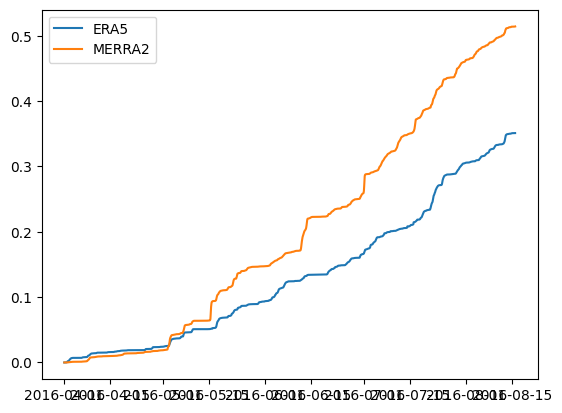

2017 0.00014598707


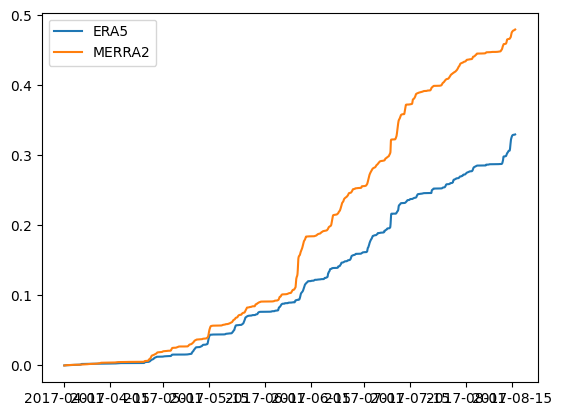

2018 0.00017880037


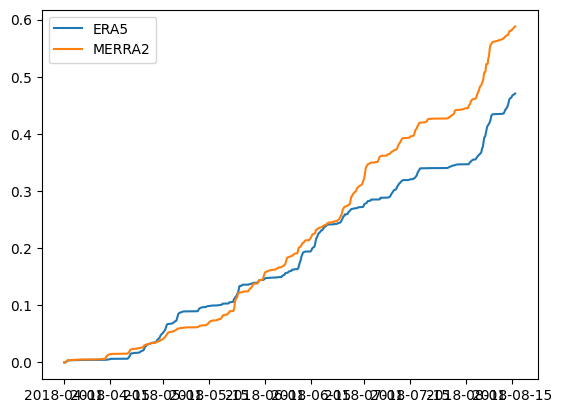

2019 0.00013557216


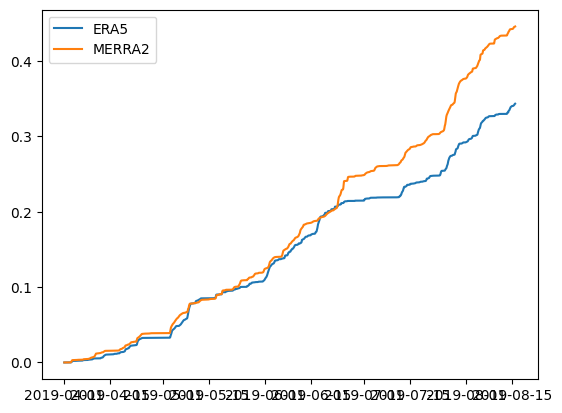

In [8]:
# PLOT MERRA2 vs ERA5
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
# OPEN MERRA2 DATASET AND SELECT TIME / LAT / LON
for year in np.arange(2015,2020):
    year = str(year)
    time_m = pd.date_range(year+'-04-01 00:30',year+'-08-15 23:30',freq='h')
    ds_merra2 = xr.open_dataset('~/research/climate_data/MERRA2/PRECTOTCORR/MERRA2_PRECTOTCORR_60_-150.nc')
    tp_m = ds_merra2.sel(lat=63.5,lon=-145.625,time=time_m)
    # OPEN ERA5 DATASET AND SELECT TIME / LAT / LON
    time_e = time_m - pd.Timedelta(minutes=30)
    ds_era5 = xr.open_dataset('~/research/climate_data/ERA5/ERA5_hourly/ERA5_precip_hourly.nc')
    tp_e = ds_era5.sel(time=time_e) # latitude=63.3,longitude=-145.5,
    tp_e = tp_e['tp'].to_numpy().flatten()
    tp_m = tp_m['PRECTOTCORR'].to_numpy()*3600/1000
    print(year,np.mean(tp_m))
    plt.plot(time_e,np.cumsum(tp_e),label='ERA5')
    plt.plot(time_m,np.cumsum(tp_m),label='MERRA2')
    plt.legend()
    plt.show()

In [9]:
df = pd.read_csv('~/research/climate_data/AWS/Preprocessed/gulkanaD/gulkana_merra2.csv')
print(np.mean(df['tp']))
plt.plot(df['datetime'],df)

1.557378538981455e-06


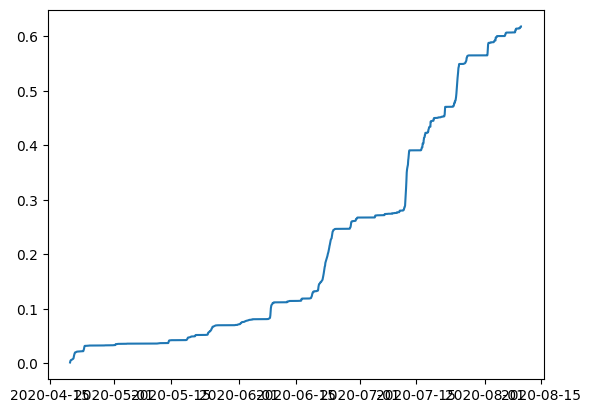

In [18]:
df = pd.read_csv('~/research/climate_data/AWS/Gulkana/gulkana1725_hourly_LVL2.csv')
# time_e = pd.date_range('2023-01-01 00:00','2019-12-31 23:00',freq='h')
df = df.rename(columns={'TPGIncremental':'tp','site_temp_USGS':'temp'})
df['tp'] = df['tp'].astype(float) / 1000
# df['tp'] = df['tp'].fillna(df['316743_72194'].astype(float))
df = df.set_index(pd.to_datetime(df['local_time']))
df = df.resample('h').mean()
df = df.loc[pd.date_range('2020-04-20 00:00','2020-08-10 00:00',freq='h')]
# print(np.sum(df['tp'].to_numpy()))
# print(np.mean(df['tp'].to_numpy()))
plt.plot(df.index,df['tp'].cumsum())
plt.show()

In [27]:
ds = xr.open_dataset('~/research/climate_data/MERRA2/MERRA2constants.nc4')
ds = ds.sel(lat=63.5,lon=-145.625)
ds.PHIS.values / 9.80665

array([1233.2357], dtype=float32)

In [1]:
# TEST SNICAR
import sys, os, yaml
sys.path.append('/home/claire/research/PyGEM-EB/biosnicar-py/src/')
import biosnicar as snicar
fp = '/home/claire/research/PyGEM-EB/biosnicar-py/src/biosnicar/inputs.yaml'
output_dict = dict()
run = 0


** Validating model configuration **
snow algae OK
illumination OK
ice OK
glacier algae OK

Running biosnicar with the adding-doubling solver



In [17]:
with open(fp) as f:
    list_doc = yaml.safe_load(f)
n_layers = 3
# Update changing layer variables
BC = [.1,.1,.1] # clean snow 0-3ppb, dirty 2-15ppb
dust = [2000,200,200] # clean snow 0-2e4 ppb, dirty 1e4-1e5 ppb
rho = [150,300,800]
grainsize = [60,800,1200]

list_doc['IMPURITIES']['BC1']['CONC'] = BC
list_doc['IMPURITIES']['BC2']['CONC'] = BC
list_doc['IMPURITIES']['DUST1']['CONC'] = [d*0.1 for d in dust]
list_doc['IMPURITIES']['DUST2']['CONC'] = [d*0.2 for d in dust]
list_doc['IMPURITIES']['DUST3']['CONC'] = [d*0.4 for d in dust]
list_doc['IMPURITIES']['DUST4']['CONC'] = [d*0.2 for d in dust]
list_doc['IMPURITIES']['DUST5']['CONC'] = [d*0.1 for d in dust]
list_doc['ICE']['DZ'] = [0.01,0.05,10]
list_doc['ICE']['RHO'] = rho
list_doc['ICE']['RDS'] = grainsize

# Following variables are set to constants, but need to have right number of layers
ice_variables = ['LAYER_TYPE','SHP','HEX_SIDE','HEX_LENGTH','SHP_FCTR','WATER','AR','CDOM']
for var in ice_variables:
    list_doc['ICE'][var] = [list_doc['ICE'][var][0]] * n_layers

# Save SNICAR input file
with open(fp, 'w') as f:
    yaml.dump(list_doc,f)

albedo = snicar.main.get_albedo('adding-doubling',plot=False,validate=False)
print(albedo)

output_dict[run] = {'BC':BC,'dust':dust,'grainsize':grainsize,
                    'rho':rho,'albedo':albedo}

run += 1


Running biosnicar with the adding-doubling solver

0.838672024069897


In [32]:
for i in range(len(output_dict)):
    print('BC:',sum(output_dict[i]['BC']),'grain size:',output_dict[i]['grainsize'],'albedo:',output_dict[i]['albedo'])

BC: 1.5e-06 grain size: [1500, 200, 200] albedo: 0.6735420373725209
BC: 1.5e-06 grain size: [1500, 200, 60] albedo: 0.6735493699844556
BC: 1.5e-06 grain size: [1500, 200, 800] albedo: 0.6735396328535006
BC: 5.5e-06 grain size: [1500, 200, 800] albedo: 0.6735396259817485
BC: 4.2000000000000004e-06 grain size: [1500, 200, 800] albedo: 0.6735397836604292
BC: 4.2000000000000004e-06 grain size: [1500, 800, 1200] albedo: 0.6735072105733765
BC: 4.2000000000000004e-06 grain size: [60, 800, 1200] albedo: 0.8393356593539523


In [1]:
# FAST IMPORT FOR TIMING
import pygem_eb.input as eb_prms
import pandas as pd
eb_prms.enddate = eb_prms.startdate + pd.Timedelta(hours=2)
import run_simulation_eb as sim
eb_prms.enddate = pd.to_datetime('2023-08-09 00:00')
import pygem_eb.massbalance as mb

Running 1 bin(s) at [1546] m a.s.l. for 4.0 months starting in April, 2023
1 glaciers in region 1 are included in this model run: ['00570']
This study is focusing on 1 glaciers in region [1]
15 layers initialized for bin 0
Total Time Elapsed: 5.2 s
Success: saving to /home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_01_17_4.nc


In [2]:
# TIMING
climateds,dates_table,utils,args = sim.initialize_model(True)
massbal = mb.massBalance(0,dates_table,args,utils)
%load_ext line_profiler
%lprun -f massbal.main massbal.main(climateds)

1 glaciers in region 1 are included in this model run: ['00570']
This study is focusing on 1 glaciers in region [1]
15 layers initialized for bin 0
MONTH COMPLETED: May 2023 with +0.00 and -0.00 m w.e.
Currently -3.52 C with 1 W m-2 melt energy
----------surface albedo: 0.850 -----------
-----------surface temp: -10.50 C-----------
|       snow depth: 2.18 m      7 layers      |
|       ice depth: 257.22 m      8 layers      |
--------------------layer 0---------------------
     T = -0.0 C                 h = 0.012 m 
                 p = 137 kg/m3
Water Mass : 0.32 kg/m2   Dry Mass : 1.66 kg/m2
--------------------layer 1---------------------
     T = -0.0 C                 h = 0.055 m 
                 p = 135 kg/m3
Water Mass : 1.52 kg/m2   Dry Mass : 7.37 kg/m2
MONTH COMPLETED: June 2023 with +0.00 and -0.11 m w.e.
Currently -2.47 C with 14 W m-2 melt energy
----------surface albedo: 0.850 -----------
-----------surface temp: -5.50 C-----------
|       snow depth: 1.64 m      7 la

Timer unit: 1e-09 s

Total time: 33.2354 s
File: /home/claire/research/PyGEM-EB/pygem_eb/massbalance.py
Function: main at line 40

Line #      Hits         Time  Per Hit   % Time  Line Contents
    40                                               def main(self,climateds):
    41                                                   """
    42                                                   Runs the time loop and mass balance scheme to solve for melt, refreeze, accumulation and runoff.
    43                                           
    44                                                   Parameters
    45                                                   ----------
    46                                                   climateds : xr.Dataset
    47                                                       Dataset containing elevation-adjusted climate data
    48                                                   """
    49                                                   # Get classes an

In [ ]:
# stupid stuff for turbulent fluxes: (get it out of the way)
    # got this from Johnson and Rupper
    # k0 = 0.4
    # zm = 10
    # zv = zh = 2
    # if snow:
    #     z0m = 0.001
    #     z0v= 0.001
    #         z0h = 0.001
    # elif ice:
    #     z0m = 0.016
    #     z0v = 0.004
    #     z0v = 0.004
    # kH = k0**2/(np.log(zm/z0m)*np.log(zv/z0v))
    # kE = k0**2/(np.log(zm/z0m)*np.log(zh/z0h))
    # density_air = gcm_sp[i][time_idx]/R_gas/gcm_temp[i][time_idx]
    # Qs = density_air*gcm_sp[0][time_idx]*cpa*kH*w10*(gcm_temp[i][time_idx]-Ts)/pressure_std
    # Ql = 0.622*density_air*kE*w10*Lv*()

    #FROM COSIPY go to surfaceTemperature.py
     # Mixing Ratio at surface and at measurement height  or calculate with other formula? 0.622*e/p = q
    #q2 = (rH2 * 0.622 * (Ew / (p - Ew))) / 100.0
    #q0 = (100.0 * 0.622 * (Ew0 / (p - Ew0))) / 100.0

In [ ]:
# ### this whole block is probably useless

# #manually set number of exponentially scaling bins
# n_vert_bins = 10
# n_points = len(geo_index)
# option_bin = 0

# #create variable to store glacier geometry
# vert_bins = xr.Dataset(data_vars = dict(
#     bin_w = (['pt'],geometry['w']),
#     pt_z = (['pt'],geometry['z'])),
#     coords=dict(
#         pt=(['pt'],geo_index),
#         vert_idx=range(n_vert_bins)
#         )
#     )

# bin_depths = np.zeros((2,n_points,n_vert_bins))
# #fill vertical bin heights based on ice thickness
# for g in range(n_points):
#     #get ice thickness of current point
#     pt_h = geometry['h'].iloc[g]
    
#     if option_bin==0:
#         hs = [0.1,.25,.5,.75,1,2,5,10,20,pt_h-39.6]
#         ds = [sum(hs[:i]) for i in range(n_vert_bins)]
#         bin_depths[:,g,:] = [hs,ds]
#     else:
#         c = opt.fsolve(lambda c: pt_h-np.sum(np.exp(np.arange(n_vert_bins)*c)),10)
#         bin_depths[g,:] = np.exp(c*range(1,n_vert_bins))
# vert_bins['bin_h'] = (['pt','vert_idx'],bin_depths[0,:,:])
# vert_bins['bin_d'] = (['pt','vert_idx'],bin_depths[1,:,:])

# #set bin content as a constant snow, firn or ice (s,f,i)
# content_arr = np.empty((n_points,n_vert_bins),dtype=str)
# content_arr[0,:] = ['i']*n_vert_bins
# content_arr[1,:] = ['f']*round(n_vert_bins*.3)+['i']*round(n_vert_bins*.7)
# content_arr[2,:] = ['s']*round(n_vert_bins*.2)+['f']*round(n_vert_bins*.2)+['i']*round(n_vert_bins*.6)
# vert_bins['bin_content'] = (['pt','vert_idx'],content_arr)

# #since using constant bin content, can also use constant properties of snow/ice
# vert_bins['lambdas'] = (['pt','vert_idx'],np.where(content_arr=='s',0.9,.8))
# vert_bins['rs'] = (['pt','vert_idx'],np.where(content_arr=='s',17.1,2.5))

In [ ]:
# # read 10 year data files for each variable in varnames and merge
# eb_varnames = ['temp','dtemp','precip','surfrad','tcc','uwind','vwind']
# i=2
# varname = 'press'
# hourlyfp = '~/research/climate_data/ERA5/ERA5_hourly/varname/ERA5_varname_hourly'.replace('varname',varname)
# da_0 = xr.open_dataarray(hourlyfp + '_80_89.nc')
# da_1 = xr.open_dataarray(hourlyfp + '_90_99.nc')
# da_2 = xr.open_dataarray(hourlyfp + '_00_09.nc')
# da_3 = xr.open_dataarray(hourlyfp + '_10_21.nc')
# print(da_0.coords)
# print(da_1.coords)
# print(da_2.coords)
# print(da_3.coords)

# da = xr.merge([da_0,da_1,da_2,da_3])
# da.to_netcdf('~/research/climate_data/ERA5/ERA5_hourly/ERA5_varname_hourly.nc'.replace('varname',varname))
# print(da)
#368,184

In [21]:
eb_varnames = ['temp','dtemp','precip','surfrad','tcc','uwind','vwind']
#eb_varnames = ['temp','press']
for varname in eb_varnames:
    hourlyfp = '~/research/climate_data/ERA5/ERA5_hourly/ERA5_varname_hourly.nc'.replace('varname',varname)
    data = xr.open_dataarray(hourlyfp)
    print(data.units)

<xarray.DataArray 't2m' (time: 368184, latitude: 1, longitude: 1)>
[368184 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -145.5
  * latitude   (latitude) float32 63.34
  * time       (time) datetime64[ns] 1980-01-01 ... 2021-12-31T23:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature
<xarray.DataArray 'sp' (time: 368184, latitude: 1, longitude: 1)>
[368184 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -145.5
  * latitude   (latitude) float32 63.33
  * time       (time) datetime64[ns] 1980-01-01 ... 2021-12-31T23:00:00
Attributes:
    units:          Pa
    long_name:      Surface pressure
    standard_name:  surface_air_pressure


In [28]:
xr.open_dataarray('~/research/climate_data/ERA5/ERA5_hourly/ERA5_geopotential.nc')

<xarray.DataArray 'z' (time: 1, latitude: 1, longitude: 1)>
array([[[13036.883]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -145.5
  * latitude   (latitude) float32 63.34
  * time       (time) datetime64[ns] 1980-01-01
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential